In [1]:
!pip install tf_agents
!pip install tf-agents[reverb]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 16.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 80.7 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697628 sha256=1999e6876112268529d95d793ddf52e67bc4a8fd82912be44d8938a775c18df4
  Stored in directory: /root/.cache/pip/wheels/3d/6f/b4/3991d4fae11d0ecb0754c11cc1b4e7745012850da4efaaf0b1
Successfully built gym
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.22.0
    Uninstalling tensorflow-probability-0.22.0:
      Successfully uninstalled tensorflow-probability-0.22.0
  Attempting uninstall: pygame
    Found existing

In [2]:
import tensorflow as tf
import tf_agents
import reverb
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tempfile
import os



from tf_agents.drivers import py_driver
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import tf_py_environment
from tf_agents.specs import tensor_spec
from tf_agents.networks import q_network
from tf_agents.networks import sequential
from tf_agents.utils import common
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import policy_saver




import sys
sys.path.append('/content/drive/MyDrive/E6885_Project')
import SortWaterEnv

In [3]:
tf.version.VERSION

'2.15.0'

In [4]:
num_iterations = 100000        #

initial_collect_steps = 100     #
collect_steps_per_iteration = 10#2#1   #
replay_buffer_max_length = 100000  #

batch_size = 64            #
learning_rate = 1e-3        #
log_interval = 200          #

num_eval_episodes = 100        #
eval_interval = 500#1000        #

In [5]:
############# create training and evaluation environment #############
num_bottles = 10
water_level = 4
env = SortWaterEnv.WaterSortEnv(num_bottles=num_bottles, water_level=water_level, random_init=True)
train_py_env = SortWaterEnv.WaterSortEnv(num_bottles=num_bottles, water_level=water_level, random_init=True)
eval_py_env = SortWaterEnv.WaterSortEnv(num_bottles=num_bottles, water_level=water_level, random_init=True)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [6]:
############ create a DQN agent ############
fc_layer_params = (500, 250)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

In [7]:
# Customized Q netword
class MaskedQNetwork(q_network.QNetwork):
  def __init__(self, input_tensor_spec, action_spec, fc_layer_params=(100,), **kwargs):
    # 从 input_tensor_spec 元组中提取观察值规格
    observation_spec = input_tensor_spec[0]

    # 调用基类的构造函数以构建网络
    super(MaskedQNetwork, self).__init__(observation_spec, action_spec, fc_layer_params=fc_layer_params, **kwargs)

  def call(self, observation, step_type=None, network_state=(), training=False):
    # 直接调用父类的 call 方法，处理观察值
    return super(MaskedQNetwork, self).call(
        observation, step_type, network_state, training)

In [8]:
observation_spec = train_env.observation_spec()
action_spec = train_env.action_spec()

# create Q-network
q_net = MaskedQNetwork(
    (observation_spec['observation'], observation_spec['action_mask']),
    action_spec,
    fc_layer_params=fc_layer_params
)

In [9]:
def observation_and_action_constraint_splitter(obs):
	return obs['observation'], obs['action_mask']

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter,
    observation_and_action_constraint_splitter=observation_and_action_constraint_splitter
)

In [11]:
# an example, just to show what policies are used during evaluation and collecting
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [12]:
# an example, just show how to create epsilon_greedy_policy. Not to be used
base_policy = agent.policy
epsilon = 0.1  # 例如，使用 0.1 作为 epsilon 值
epsilon_greedy_policy = epsilon_greedy_policy.EpsilonGreedyPolicy(base_policy, epsilon=epsilon)

In [13]:
# example of greedy policy choosing action
example_py_env = SortWaterEnv.WaterSortEnv(num_bottles=num_bottles, water_level=water_level, random_init=True)
example_env = tf_py_environment.TFPyEnvironment(example_py_env)
time_step = example_env.reset()
print(time_step)
epsilon_greedy_policy.action(time_step)

TimeStep(
{'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': {'observation': <tf.Tensor: shape=(1, 10, 4), dtype=int32, numpy=
array([[[1, 6, 6, 7],
        [2, 2, 2, 6],
        [3, 3, 3, 5],
        [4, 4, 4, 4],
        [5, 5, 5, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [8, 8, 8, 7],
        [8, 1, 7, 7],
        [3, 1, 2, 6]]], dtype=int32)>,
                 'action_mask': <tf.Tensor: shape=(1, 90), dtype=bool, numpy=
array([[False, False, False, False,  True,  True, False, False, False,
        False, False, False, False,  True,  True, False, False, False,
        False, False, False, False,  True,  True, False, False, False,
        False, False, False, False,  True,  True, False, False, False,
        False, False, False, False,  True,  True, Fals

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([86], dtype=int32)>, state=(), info=())

In [14]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [15]:
# an example
compute_avg_return(eval_env, epsilon_greedy_policy, num_eval_episodes)

-1.0

In [16]:
################# Replay buffer #################
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

In [17]:
agent.collect_data_spec

_TupleWrapper(Trajectory(
{'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'observation': BoundedTensorSpec(shape=(10, 4), dtype=tf.int32, name='observation', minimum=array(0, dtype=int32), maximum=array(8, dtype=int32)), 'action_mask': TensorSpec(shape=(90,), dtype=tf.bool, name='action_mask')}),
 'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(89, dtype=int32)),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))}))

In [18]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [19]:
# an example.
py_driver.PyDriver(
    train_py_env,
    py_tf_eager_policy.PyTFEagerPolicy(
      epsilon_greedy_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'step_type': array(1, dtype=int32),
  'reward': array(0., dtype=float32),
  'discount': array(1., dtype=float32),
  'observation': {'observation': array([[0, 0, 0, 0],
        [4, 4, 4, 4],
        [1, 1, 0, 0],
        [2, 2, 2, 0],
        [7, 7, 7, 7],
        [6, 6, 6, 6],
        [3, 3, 3, 0],
        [8, 8, 8, 8],
        [2, 5, 5, 3],
        [1, 1, 5, 5]], dtype=int32),
                  'action_mask': array([False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False,
      

In [20]:
env.get_state()

{'observation': array([[0, 0, 0, 0],
        [2, 2, 2, 3],
        [1, 6, 6, 1],
        [4, 4, 4, 6],
        [5, 5, 3, 8],
        [0, 0, 0, 0],
        [7, 7, 7, 3],
        [8, 8, 8, 4],
        [7, 5, 5, 1],
        [2, 3, 1, 6]], dtype=int32),
 'action_mask': array([False, False, False, False, False, False, False, False, False,
         True, False, False, False,  True, False, False, False, False,
         True, False, False, False,  True, False, False, False, False,
         True, False, False, False,  True, False, False, False, False,
         True, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True, False, False, False, False,  True, False, False, False,
         True, False, False, False, False,  True, False, False, False,
         True, False, False, False, False,  True, False, False, False,
         True, False, False, False, False,  True, False, False, False])}

In [21]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<_PrefetchDataset element_spec=(Trajectory(
{'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': DictWrapper({'observation': TensorSpec(shape=(64, 2, 10, 4), dtype=tf.int32, name=None), 'action_mask': TensorSpec(shape=(64, 2, 90), dtype=tf.bool, name=None)}),
 'action': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [22]:
iterator = iter(dataset)

In [23]:
# demo: only 1 episode
agent.train = common.function(agent.train)

agent.train_step_counter.assign(0)

avg_return = compute_avg_return(eval_env, agent.policy, 1)

In [24]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    train_py_env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

######### early stopping ##########
# set save direction
tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())
# checkpointer
# checkpoint_dir = os.path.join(tempdir, 'checkpoint')
# train_checkpointer = common.Checkpointer(
#     ckpt_dir=checkpoint_dir,
#     max_to_keep=1,
#     agent=agent,
#     policy=agent.policy,
#     replay_buffer=replay_buffer,
#     global_step=train_step_counter
# )
# policy saver
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

# some threshold
#best_avg_return = -float('inf')
best_avg_return = 0.7
no_improvement_steps = 0
early_stopping_threshold = 10
earlystop = False
iter_thres = 10000
######### early stopping ##########


iter_count = 0
for _ in range(num_iterations):
  iter_count += 1
  #print('iter_count: ',iter_count)
  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

  ######### early stopping ##########
    if avg_return > best_avg_return:
      earlystop = True
    if (avg_return > best_avg_return) and earlystop and (iter_count > iter_thres):
      best_avg_return = avg_return
      no_improvement_steps = 0
      tf_policy_saver.save(policy_dir)  # save policy
    elif earlystop and (iter_count > iter_thres):
      no_improvement_steps += 0
    print("no_improvement_steps: ",no_improvement_steps)
  if no_improvement_steps >= early_stopping_threshold:
    print("No improvement for {0} steps. Early stopping...".format(no_improvement_steps))
    break
  ######### early stopping ##########

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 200: loss = 21024076.0
step = 400: loss = 250304688.0
step = 500: Average Return = -1.0
no_improvement_steps:  0
step = 600: loss = 21602046.0
step = 800: loss = 8712065.0
step = 1000: loss = 5645407.0
step = 1000: Average Return = -1.0
no_improvement_steps:  0
step = 1200: loss = 689928.4375
step = 1400: loss = 468532.1875
step = 1500: Average Return = -0.9599999785423279
no_improvement_steps:  0
step = 1600: loss = 110989.25
step = 1800: loss = 25279.328125
step = 2000: loss = 8531.416015625
step = 2000: Average Return = -0.9800000190734863
no_improvement_steps:  0
step = 2200: loss = 5859.39208984375
step = 2400: loss = 1983.024658203125
step = 2500: Average Return = -0.9599999785423279
no_improvement_steps:  0
step = 2600: loss = 1489.4410400390625
step = 2800: loss = 3576.656005859375
step = 3000: loss = 1704.7164306640625
step = 3000: Average Return = -0.9800000190734863
no_improvement_steps:  0
step = 3200: loss = 1105.500244140625
step = 3400: loss = 557.1576538085938
st

In [25]:
try:
  saved_policy = tf.saved_model.load(policy_dir)
  avg_return = compute_avg_return(eval_env, saved_policy, 1000)
  print(avg_return)
  avg_return = compute_avg_return(train_env, saved_policy, 1000)
  print(avg_return)
except:
  pass

Text(0.5, 0, 'Iterations')

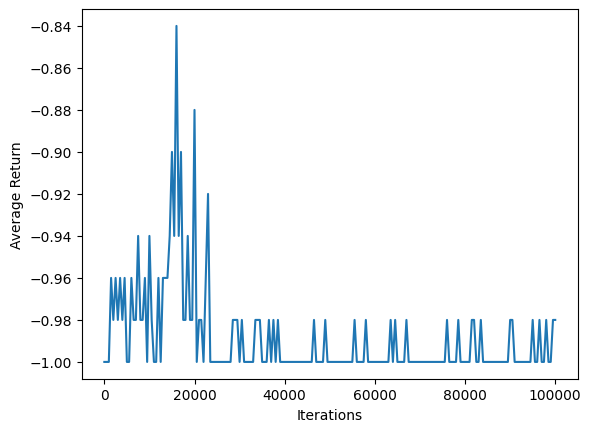

In [29]:
iterations = range(0, iter_count + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
#plt.ylim(top=250)

In [30]:
from google.colab import files
import csv

with open('10b_returns.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(list(iterations))
  writer.writerow(returns)

files.download('10b_returns.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>